## Installing dependencies

In [1]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.interpolate import interp1d
from sklearn.gaussian_process.kernels import RBF
import torch
from sklearn.preprocessing import StandardScaler
import warnings
from tsai.all import *
import sklearn.metrics as skm
from IPython.display import clear_output
import copy
my_setup()
warnings.simplefilter('ignore')

os              : Linux-5.15.133+-x86_64-with-glibc2.31
python          : 3.10.13
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.2
device          : 1 gpu (['Tesla P100-PCIE-16GB'])
cpu cores       : 2
threads per cpu : 2
RAM             : 31.36 GB
GPU memory      : [16.0] GB


In [3]:
X_rand = np.load("/kaggle/input/np-arrays/X_rand_samp.npy")
y_wtd = np.load("/kaggle/input/np-arrays/y_wtd_samp.npy")
X_wtd=np.load('/kaggle/input/np-arrays/X_wtd_samp.npy')
y_rand= np.load('/kaggle/input/np-arrays/y_rand_samp.npy')


In [4]:
from sklearn.model_selection import train_test_split
# Further split the training set into train and validation sets (75/25 split)
X_train, X_val, y_train, y_val = train_test_split(X_wtd, y_wtd, test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)


### Initializing data

In [5]:
bs = 16
X, y, splits = combine_split_data([X_train, X_val], [y_train, y_val])
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs])


### Finding a good initial learning rate for the model before tuning

In [6]:
# learn = Learner(dls, model_to_train(dls.vars, dls.c, dls.len), metrics=[F1Score(average='macro')])
# learn.lr_find()

### Hyperparam tuning of the MODEL

In [7]:
# Use best initial epochs and max_lr
epochs = 25
max_lr = 1e-3

In [8]:
from fastai.callback.tracker import *
early_stopping = EarlyStoppingCallback(patience=3, min_delta=0.05)

* Conclusions from 
* model1: RNNPlus
* model2: RNNAttention
* https://docs.google.com/document/d/1skeTIoSMsVwEUPVI6HAi7rVfM1dVMvA0BYECeTmwUvQ/edit?usp=sharing
* LSTM, GRU not used as RNN showed better results


In [9]:
# Focus on RNNPlus hyperparameters, ignore irrelevant ones
model_2 = RNNPlus
max_lr = 2.12e-4
seq_len = [  # Set based on your sequence length or strategy
    # ... (e.g., different fixed lengths or truncation methods)
]
hidden_size = [1024]  # Experiment with different sizes
n_layers = [4]  # Try 1-3 layers
rnn_dropout = [0.1]  # Starting points for dropout

archs_2 = []
# for out_classes in c_out:
# for length in seq_len:
for h_size in hidden_size:
        for layers in n_layers:
#           for lr in learning_rate:
            for dropout in rnn_dropout:
              archs_2.append((model_2, {
#                 'c_in': your_input_channels,  # Set based on your data shape
#                 'c_out': out_classes,
#                 'seq_len': length,
                'hidden_size': h_size,
                'n_layers': layers,
                'rnn_dropout': dropout,
                # Ignore other less important parameters for now
              }))


In [10]:
# {'d_model': 64, 'depth': 8, 'lstm_dropout': 0.1, 'dropout': 0.1, 'mlp_ratio': 4, 'n_layers': 4, 'hidden_size': 512, 'use_pe': True
model_3= TSSequencerPlus
d_model = [64]
depth = [8]
lstm_dropout = [0.1]
dropout = [0.1]
mlp_ratio = [6]
archs_3 = []
for dimension in d_model:
    for transfblock in depth:
      for tfr_dropout in dropout:
        for lstmdropout in lstm_dropout:
          for mlp_dim_ratio in mlp_ratio:
            archs_3.append((model_3, {
              'd_model': dimension,  # Add d_model for embedding dimension
              'depth': transfblock,  # Add depth for number of transformer blocks
              'lstm_dropout': lstmdropout,
              'dropout': tfr_dropout,  # Use tfr_dropout for transformer dropout
              'mlp_ratio': mlp_dim_ratio,
#               'n_layers': 4,
#               'hidden_size': 512,
              'use_pe': True,  # Enable positional encoding by default
              # Remove commented-out lines for unused parameters
            }))

In [46]:

# Focus on InceptionTime hyperparameters, remove unnecessary sections
model_4 = InceptionTime
nf = [1024]
nb_filters = [128]
ks = [3, 5, 7]
bottleneck = [True]  # Experiment with both options

archs_4 = []
for f in nf:
    for num_filters in nb_filters:
#       for kernel_size in ks:
        for use_bottleneck in bottleneck:
          archs_4.append((model_4, {
            'c_in': dls.vars,  # Assuming grayscale keypoint data
            'c_out': dls.c,  # Replace with actual number of activities
            'nf': f,
            'nb_filters': num_filters,
#             'ks': kernel_size,
            'bottleneck': use_bottleneck,
          }))


In [22]:
model_5 = TransformerRNNPlus
d_model = [32, 64, 128]
nhead = [4, 8, 16]
num_encoder_layers = [1, 2, 4]
dim_feedforward = [2 * d for d in d_model]  # Based on d_model values
dropout = [0.1, 0.2, 0.3]
num_rnn_layers = [1, 2, 3]  # Adjust if handling longer sequences

archs_5 = []
for d in d_model:
    for h in nhead:
      for e in num_encoder_layers:
        for ff in dim_feedforward:
          for dr in dropout:
            for rnn in num_rnn_layers:
              archs_5.append((model_5, {
#                 'c_in': 1,  # Assuming grayscale keypoint data
#                 'c_out': len(your_activity_classes),
                'd_model': d,
                'nhead': h,
                'num_encoder_layers': e,
                'dim_feedforward': ff,
                'dropout': dr,
                'num_rnn_layers': rnn,
              }))


In [23]:
model_6 = TSTPlus
n_layers = [2, 4, 6]
d_model = [64, 128, 256]
n_heads = [4, 8, 16]
d_ff = [d * 2 for d in d_model]  # Start with d_ff = 2 * d_model
attn_dropout = [0.1, 0.2, 0.3]
dropout = [0.1, 0.2, 0.3]
max_seq_len = [  # Adjust based on your data's average/max sequence length
    min(512, int(np.mean(your_sequence_lengths))),
    min(512, np.max(your_sequence_lengths))
]
learn_pe = [True, False]  # Experiment with both options

archs_6 = []
for layers in n_layers:
    for dim in d_model:
      for heads in n_heads:
        for use_dropout in attn_dropout:
          for lstm_dropout in dropout:
            archs_6.append((model_6, {
              'n_layers': layers,
              'd_model': dim,
              'n_heads': heads,
              'd_ff': d_ff[d_model.index(dim)],
              'attn_dropout': use_dropout,
              'dropout': lstm_dropout,
              'max_seq_len': max_seq_len[0],  # Consider using both lengths later
              'learn_pe': learn_pe[0],  # Consider both True/False later
              # Set other parameters based on your data and preferences
            }))


NameError: name 'your_sequence_lengths' is not defined

In [24]:
model_7 = PatchTST # Assuming you want to keep PatchTST
n_layers = [2, 4, 6]  # Experiment with more layers based on resources
d_model = [128, 256, 512]  # Adjust based on data complexity and memory
patch_len = [8, 16, 32]  # Consider activity duration and sequence length
stride = [1, 2, 4]  # Keep stride smaller than patch_len
n_heads = [4, 8, 16]  # Start with lower values and increase if needed
dropout = [0.1, 0.2, 0.3]  # Regularization for overfitting prevention

archs_7 = []
for layers in n_layers:
    for dim in d_model:
      for p_len in patch_len:
        for p_stride in stride:
          for heads in n_heads:
            for dr in dropout:
              archs_7.append((model_7, {
                'n_layers': layers,
                'd_model': dim,
                'patch_len': p_len,
                'stride': p_stride,
                'n_heads': heads,
                'dropout': dr,
                # Other parameters with default or less impact values
              }))


model8 = SequentialRNN
model9 = ResNet

In [47]:
model_to_train=model_4
archs = archs_4

In [48]:
# Create DataFrame to store results
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'f1_score', 'time', 'epochs', 'max_lr'])
model = create_model(model_to_train, dls=dls, **(archs[0][1]))
for i, (arch, k) in enumerate(archs):
    model_copy = copy.deepcopy(model)  

    print(model.__class__.__name__, '\n', k)
    learn = Learner(dls, model_copy, metrics=[F1Score(average='macro')], 
                   cbs=[early_stopping,]
                   )
    start = time.time()
    learn.fit_one_cycle(epochs, max_lr)  # Use correct epochs and lr for each iteration
    elapsed = time.time() - start
    
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed), epochs, max_lr]
    results.sort_values(by='f1_score', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results.head(10))


,arch,hyperparams,total params,train loss,valid loss,f1_score,time,epochs,max_lr
0,InceptionTime,"{'c_in': 1, 'c_out': 9, 'nf': 1024, 'nb_filters': 128, 'bottleneck': True}",98392073,1.244078,2.583629,0.171726,111,25,0.000767
1,InceptionTime,"{'c_in': 1, 'c_out': 9, 'nf': 700, 'nb_filters': 128, 'bottleneck': True}",98392073,1.092129,1.515655,0.141412,199,25,0.000767
2,InceptionTime,"{'c_in': 1, 'c_out': 9, 'nf': 600, 'nb_filters': 128, 'bottleneck': True}",98392073,1.269977,2.446108,0.078158,88,25,0.000767
3,InceptionTime,"{'c_in': 1, 'c_out': 9, 'nf': 512, 'nb_filters': 128, 'bottleneck': True}",98392073,1.254339,5.439857,0.055309,88,25,0.000767


### Finding optimal starting LR for the tuned model

SuggestedLRs(valley=0.0008317637839354575)

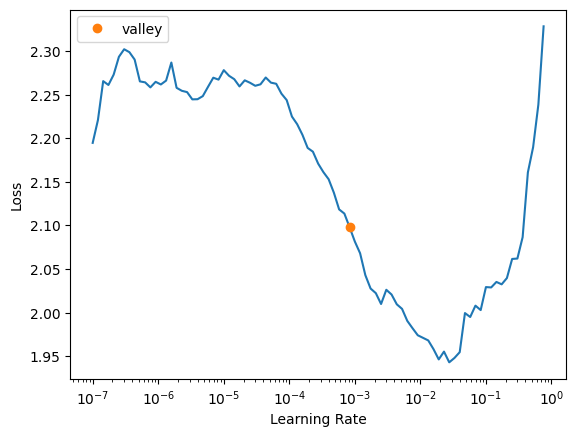

In [51]:
learn = Learner(dls, model_3(dls.vars, dls.c, dls.len, d_model = 64,
depth = 8,
lstm_dropout = 0.1,
dropout = 0.1,
mlp_ratio = 6))
learn.lr_find()

### Tuning n_epochs and max_learning_rate

In [ ]:
model_to_tune = model_3

In [17]:
# Fixed model hyperparameters
k = {'d_model' : 64,
'depth' : 8,
'lstm_dropout' : 0.1,
'dropout' : 0.1,
'mlp_ratio' : 6}

# Define options for epochs and max_lr
epochs_options = [25]
base_lr =0.000757
del_lr = 0.00001
max_lrs = [base_lr-del_lr*2, base_lr-del_lr, base_lr, base_lr +del_lr, base_lr +del_lr*2]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'f1_score', 'time', 'epochs', 'max_lr'])
model = create_model(TSSequencerPlus, dls=dls, **k)
learn = Learner(dls, model, metrics=[F1Score(average='macro')], 
                   cbs=[early_stopping,])
for epochs in epochs_options:
   for max_lr in max_lrs:
         # Create model within the loop
       print(model.__class__.__name__)
       start = time.time()
       learn.fit_one_cycle(epochs, max_lr)
       elapsed = time.time() - start
       vals = learn.recorder.values[-1]

       results.loc[len(results)] = [
           model.__class__.__name__,
           k,
           count_parameters(model),
           vals[0],
           vals[1],
           vals[2],
           int(elapsed),
           epochs,
           max_lr
       ]
       results.sort_values(by='f1_score', ascending=False, kind='stable', ignore_index=True, inplace=True)
       clear_output()
       display(results)

,arch,hyperparams,total params,train loss,valid loss,f1_score,time,epochs,max_lr
0,TSSequencerPlus,"{'d_model': 64, 'depth': 8, 'lstm_dropout': 0.1, 'dropout': 0.1, 'mlp_ratio': 6}",24217785,0.533313,0.957078,0.434119,14,25,0.000757
1,TSSequencerPlus,"{'d_model': 64, 'depth': 8, 'lstm_dropout': 0.1, 'dropout': 0.1, 'mlp_ratio': 6}",24217785,0.606759,0.922047,0.383464,14,25,0.000747
2,TSSequencerPlus,"{'d_model': 64, 'depth': 8, 'lstm_dropout': 0.1, 'dropout': 0.1, 'mlp_ratio': 6}",24217785,0.488717,0.992720,0.370289,14,25,0.000767
3,TSSequencerPlus,"{'d_model': 64, 'depth': 8, 'lstm_dropout': 0.1, 'dropout': 0.1, 'mlp_ratio': 6}",24217785,0.736166,0.927089,0.340033,14,25,0.000737
4,TSSequencerPlus,"{'d_model': 64, 'depth': 8, 'lstm_dropout': 0.1, 'dropout': 0.1, 'mlp_ratio': 6}",24217785,0.936098,1.117605,0.297898,39,25,0.000727


## Conclusion:


1.   RNNPlus: n_layers = 4, hidden_size = 1024, epochs=75, max_lr=2.12e-4
2.   RNNAttention:
`rnn_layers_options = [3]  
hidden_size_options = [1024]  
encoder_layers_options = [3]  
dropout_options = [0.2]
max_lr=1.65e-5 
epochs=75`

7. InceptionTime
7. TSSequencerPlus:
>     dls.vars, dls.c, dls.len, d_model = 64,
> depth = 8,
> lstm_dropout = 0.1,
> dropout = 0.1,
> mlp_ratio = 6))
> max_lr= 0.000757
9. TransformerRNNPlus
10. TSTPlus
11. PatchTST
12. ResNet
13. xresnet1d34_deeperplus




